*** 
                                    The following are data descriptions.
***
***
**Id**-an Id that represents a (Store, Date) duple within the test set<br>
**Store**-a unique Id for each store<br>
**Sales** - the turnover for any given day (this is what you are predicting)<br>
**Customers** - the number of customers on a given day<br>
**Open** - an indicator for whether the store was open: `0 = closed, 1 = open`<br>
**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.`a = public holiday, b = Easter holiday, c = Christmas, 0 = None`<br>
**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools<br>
**StoreType** - differentiates between 4 different store models: a, b, c, d<br>
**Assortment** - describes an assortment level: `a = basic, b = extra, c = extended.` Read more about assortment here<br>
**CompetitionDistance** - distance in meters to the nearest competitor store<br>
**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened<br>
**Promo** - indicates whether a store is running a promo on that day<br>
**Promo2** - Promo2 is a continuing and consecutive promotion for some stores:`0 = store is not participating, 1 = store is participating`<br>
**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2<br>
**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
***

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#for easy access to path
import sys
import os

#importing packages for data manuplation and visualization
import numpy as np
import pandas as pd
import math

# Modelling Algorithm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Modelling Helpers
#from sklearn.preprocessing import Imputer, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Visualization Configuration
%matplotlib inline
sns.set()

In [2]:
#Acessing scripts and data path
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')

In [3]:
#import local libraries
from clean_train_test_df import CleanStoreDf
from data_preview import DataPreview
from data_loader import load_df_from_csv
from data_manipulation import DataManipulator
from plots import *
from result import ResultPicker

In [4]:
#reading our data
pd.set_option('max_column', None)
pd.set_option('max_rows', None)

store_df=pd.read_csv('../data/store.csv')
train_df=pd.read_csv('../data/train.csv')
test_df=pd.read_csv('../data/test.csv')

#creating an object
store_data=DataPreview(store_df)
train_data=DataPreview(train_df)
test_data=DataPreview(test_df)

In [5]:
results = ResultPicker()

###### STORE DATASET

In [6]:
#check if the data has null values
missing = store_data.percent_missing(store_df)
results.add_data('missing_data',missing)
missing

#get the missing percenatage in each columns
store_data.missing_values_table()

The dataset contains 21.01 % missing values.


,total_missing_values,missing_percentage
Promo2SinceWeek,544,48.79 %
Promo2SinceYear,544,48.79 %
PromoInterval,544,48.79 %
CompetitionOpenSinceMonth,354,31.75 %
CompetitionOpenSinceYear,354,31.75 %
CompetitionDistance,3,0.27 %
Store,0,0.0 %
StoreType,0,0.0 %
Assortment,0,0.0 %
Promo2,0,0.0 %


> The store data has 21.01% missing values.
>>`Promo2SinceWeek`,`Promo2SinceYear` and `PromoInterval` has higher missing values and need to be dropped.	

###### TRAIN DATASET AND TEST DATASET

In [7]:
train_data.show_datatypes()

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [8]:
test_data.show_datatypes()

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
dtype: object

In [9]:
#check if the data has null values
train_data.percent_missing(train_df)
test_data.percent_missing(test_df)

The dataset contains 0.0 % missing values.
The dataset contains 0.0 % missing values.


>Both `Train` and `Test` dataset has no missing vlaues.

In [10]:
#changin the datatype
train_data_cleaner = CleanStoreDf(train_df)
test_data_cleaner = CleanStoreDf(test_df)

In [11]:
train_data_cleaner.change_column_to_date_type('Date')
test_data_cleaner.change_column_to_date_type('Date')

In [12]:
test_data_cleaner.df.dtypes

Id                        int64
Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday             int64
dtype: object

>The `Date` column was object type and need to be changed for extracting the year,months and days.<br>
>The data type of date column is changed to datetime as seen in the output

In [13]:
# Separating date for train and test
train_data_cleaner.separate_date_column(date_column='Date')
test_data_cleaner.separate_date_column(date_column='Date')

In [14]:
train_data_cleaner.df.dtypes

Store             int64
DayOfWeek         int64
Year              int64
Month             int64
Day               int64
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

>The date column is separated into `Year`,`Month` and `Day`.

### <font color='saddlebrown'> Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?</font>

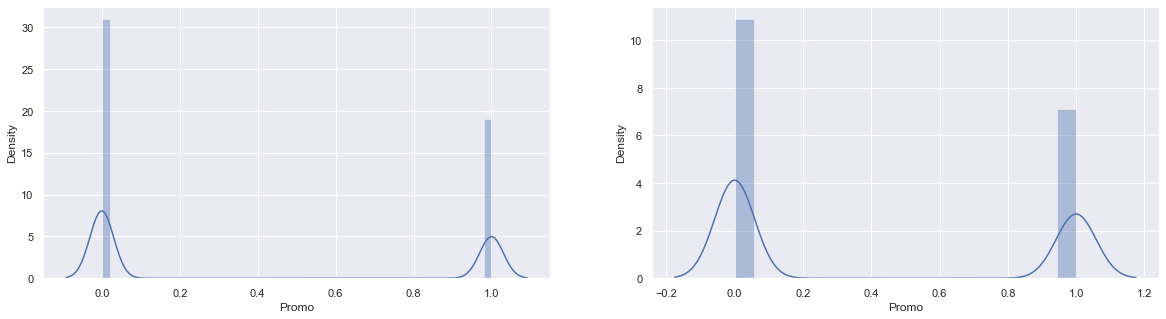

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(train_df['Promo'],ax=axs[0])#.set_title('Distribution of Train Promo)
sns.distplot(test_df['Promo'],ax=axs[1])#.set_title('Distribution of Test Promo')
plt.savefig('../screenshots/TrianTestDist.png')

>Distribution of Train and Test Promo

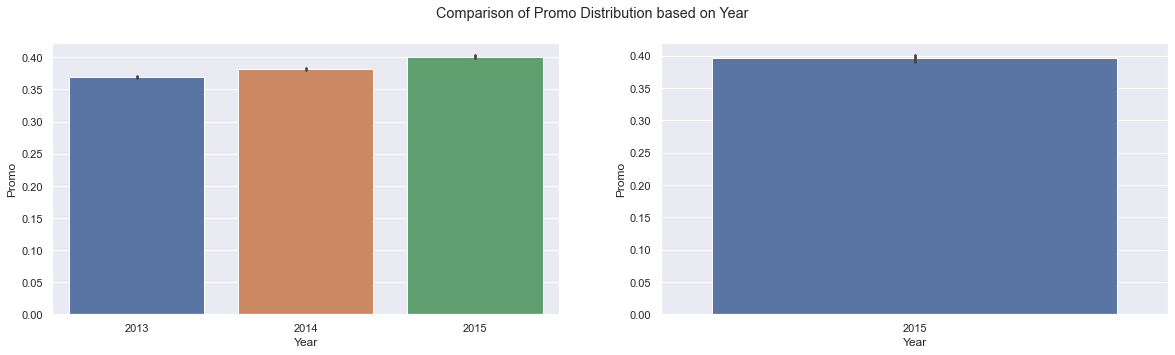

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(f'Comparison of Promo Distribution based on Year')
sns.barplot('Year',"Promo", data=train_df,ax=axs[0])
sns.barplot('Year',"Promo", data=test_df,ax=axs[1])
plt.savefig('../screenshots/PromoComaprision.png')

>Promotion was used only in 2015 for test data while  it was used for three consecutive years for train.

### <font color='saddlebrown'>Comparison of sales behavior before, during and after holidays.</font>

##### SCHOOL HOLIDAYS

In [18]:
train_df['SchoolHoliday'].unique()
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Day', 'Sales',
       'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday'],
      dtype='object')

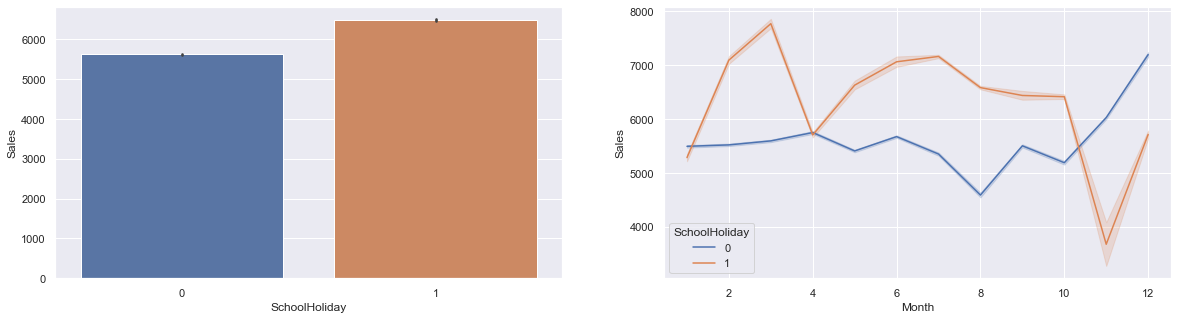

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot('SchoolHoliday',"Sales", data=train_df,ax=axs[0])
sns.lineplot(x='Month', y='Sales', hue='SchoolHoliday', data=train_df,ax=axs[1])
plt.savefig('../screenshots/SchoolHolidaySales.png')

>Sales druing school Holydays are higher.

##### STATE HOLIDAYS

In [20]:
train_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

`a = public holiday, b = Easter holiday, c = Christmas, 0 = None`<br>

(array([15706., 15826., 15949., 16071., 16191., 16314., 16436., 16556.,
        16679.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

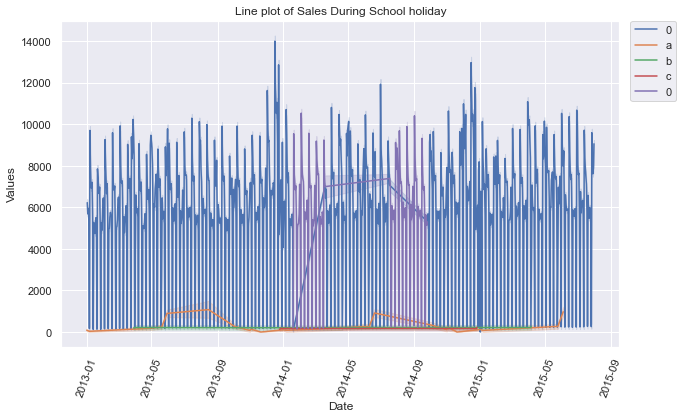

In [21]:
f, ax = plt.subplots(figsize=(10, 6))
lp = sns.lineplot(x='Date', y='Sales', hue='StateHoliday', data=train_df)

#Position the legend out the graph
lp.legend(bbox_to_anchor=(1.02, 1),
          loc=2, 
          borderaxespad=0.0);
lp.set(title='Line plot of Sales During School holiday', xlabel='Year', ylabel='Values')
plt.xlabel('Date')
plt.xticks(rotation=70)

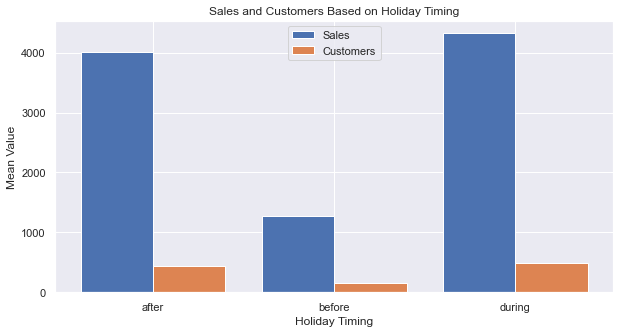

In [22]:
def affect_list(change_list, interval, duration, index):
    start_pt = int(index-duration/2) - interval
    try:
        for index in range(start_pt, start_pt + interval):
            change_list[index] = 'before'
        for index in range(start_pt + interval, start_pt + interval + duration):
            change_list[index] = 'during'
        for index in range(start_pt + interval + duration, start_pt + interval + duration + interval):
            change_list[index] = 'after'
    except:
        pass

    return change_list


state_holiday_list = train_df['StateHoliday'].values.tolist()
def modify_holiday_list(holiday_list:list) -> list:
    new_index = ["neither"] * len(holiday_list)
    for index , value in enumerate(holiday_list):
        if value == 'a': #public holiday
            affect_list(new_index, 3, 1, index)
        elif value == 'b': #Easter
            affect_list(new_index, 10, 50, index)
        elif value == 'c': # christmas
            affect_list(new_index, 5, 12, index)
        else:
            pass

    return new_index
    
sales_timing_list = modify_holiday_list(state_holiday_list)
timing_added_df = train_df.loc[:,['Sales','Customers']]
timing_added_df['HolidayTiming'] = sales_timing_list
grouped_timing = timing_added_df.groupby('HolidayTiming').agg(
    {'Sales': 'mean', 'Customers': 'mean'})
grouped_timing = grouped_timing.iloc[:3, :]

plt.figure(figsize=(10,5))
X_axis = np.arange(len(grouped_timing.index))
plt.bar(X_axis - 0.2, grouped_timing['Sales'], 0.4, label='Sales')
plt.bar(X_axis + 0.2, grouped_timing['Customers'], 0.4, label='Customers')

plt.xticks(X_axis, grouped_timing.index)
plt.xlabel("Holiday Timing")
plt.ylabel("Mean Value")
plt.title("Sales and Customers Based on Holiday Timing")
plt.legend()
plt.savefig('../screenshots/SalesOnStateHoliday.png')

### <font color='saddlebrown'>Find out any seasonal (Christmas, Easter etc) purchase behaviours.</font>

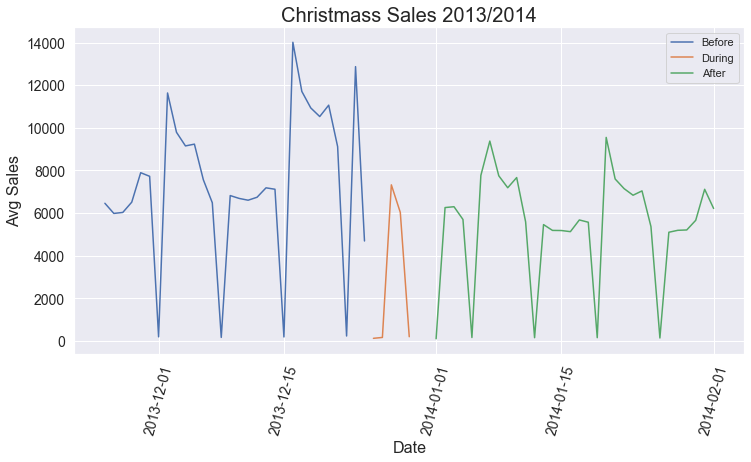

<Figure size 432x288 with 0 Axes>

In [28]:
before_index = (train_df["Date"] >= pd.to_datetime("2013-11-25")) & (train_df["Date"] < pd.to_datetime("2013-12-25"))
before_xmass = train_df[before_index].groupby("Date").agg({"Sales": "mean"})

during_index = (train_df["Date"] >= pd.to_datetime("2013-12-25")) & (train_df["Date"] < pd.to_datetime("2013-12-30"))
during_xmass = train_df[during_index].groupby("Date").agg({"Sales": "mean"})

after_index = (train_df["Date"] >= pd.to_datetime("2014-01-01")) & (train_df["Date"] < pd.to_datetime("2014-02-02"))
after_xmass = train_df[after_index].groupby("Date").agg({"Sales": "mean"})


plt.figure(figsize=(12, 6))

sns.lineplot(x = before_xmass.index, y = before_xmass["Sales"], label='Before')
sns.lineplot(x = during_xmass.index, y = during_xmass["Sales"], label='During')
sns.lineplot(x = after_xmass.index, y = after_xmass["Sales"], label='After')

plt.title("Christmass Sales 2013/2014", size=20)
plt.xticks(rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel="Date", fontsize=16)
plt.ylabel(ylabel="Avg Sales", fontsize=16)
plt.show()
plt.savefig('../screenshots/ChristmasSales2014.png')

>The last two weeks before Christmas had the largest peak of sales over the two-month holiday season.

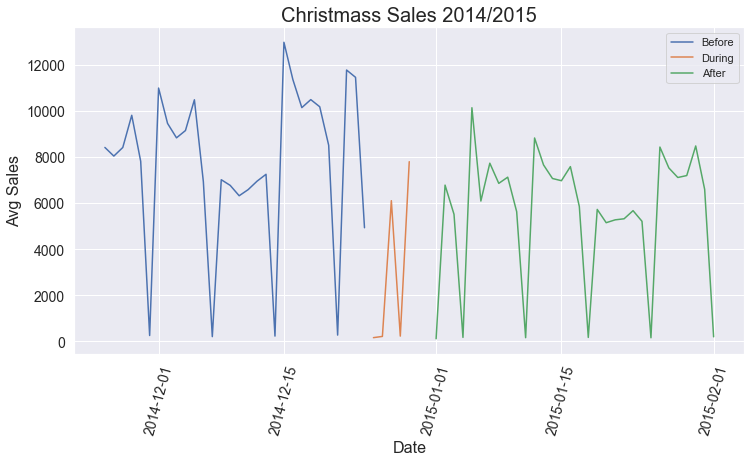

<Figure size 432x288 with 0 Axes>

In [29]:
before_index = (train_df["Date"] >= pd.to_datetime("2014-11-25")) & (train_df["Date"] < pd.to_datetime("2014-12-25"))
before_xmass = train_df[before_index].groupby("Date").agg({"Sales": "mean"})

during_index = (train_df["Date"] >= pd.to_datetime("2014-12-25")) & (train_df["Date"] < pd.to_datetime("2014-12-30"))
during_xmass = train_df[during_index].groupby("Date").agg({"Sales": "mean"})

after_index = (train_df["Date"] >= pd.to_datetime("2015-01-01")) & (train_df["Date"] < pd.to_datetime("2015-02-02"))
after_xmass = train_df[after_index].groupby("Date").agg({"Sales": "mean"})


plt.figure(figsize=(12, 6))

sns.lineplot(x = before_xmass.index, y = before_xmass["Sales"], label='Before')
sns.lineplot(x = during_xmass.index, y = during_xmass["Sales"], label='During')
sns.lineplot(x = after_xmass.index, y = after_xmass["Sales"], label='After')

plt.title("Christmass Sales 2014/2015", size=20)
plt.xticks(rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel="Date", fontsize=16)
plt.ylabel(ylabel="Avg Sales", fontsize=16)
plt.show()
plt.savefig('../screenshots/ChristmasSales2015.png')

### <font color='saddlebrown'>What can you say about the correlation between sales and number of customers?</font>

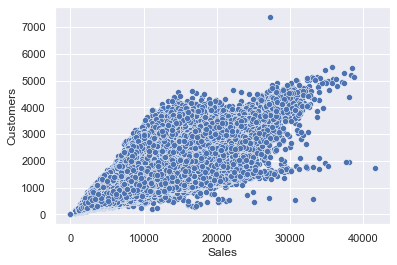

In [30]:
customer_sales_df = train_df[["Date", "Sales", "Customers"]]
sns.scatterplot(data=customer_sales_df, x='Sales', y='Customers')
plt.savefig('../screenshots/SaleCustCorr.png')

,Sales,Customers
Sales,1.000000,0.894711
Customers,0.894711,1.000000


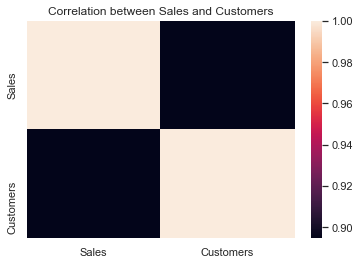

<Figure size 504x504 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [31]:
# plotting the correlations onto a heatmap
sales_customers_corr = train_df[["Sales", "Customers"]].corr()
display(sales_customers_corr)
sns.heatmap(sales_customers_corr)
plt.title('Correlation between Sales and Customers')
plt.figure(figsize=(7, 7))
plt.show()
plt.savefig('../screenshots/SaleCustCorrHeat.png')

##### aditional heatmap for better visuilization

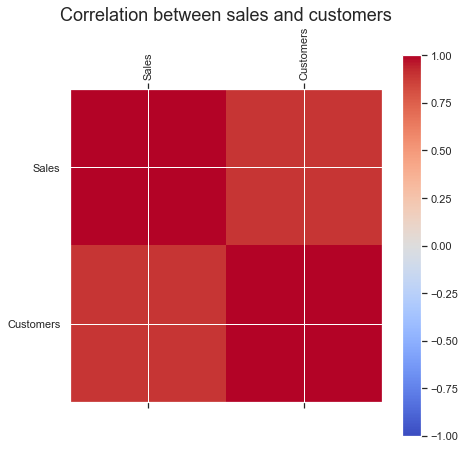

In [32]:
df_corr=train_df[['Sales','Customers']]
corr = df_corr.corr()

# plotting the correlations onto a heatmap
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
plt.title('Correlation between sales and customers',size=18)
ax.set_yticks(ticks)
ax.set_xticklabels(df_corr.columns)
ax.set_yticklabels(df_corr.columns)
plt.show()

### <font color='saddlebrown'>How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?</font>


##### How does promo affect sales?

###### DAY

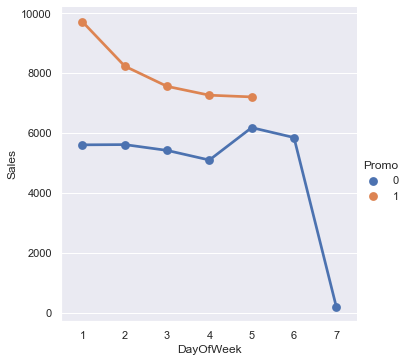

In [34]:
sns.factorplot(data = train_df, x ="DayOfWeek", y = "Sales",
                hue='Promo'
              ,sharex=False)

###### MONTHS

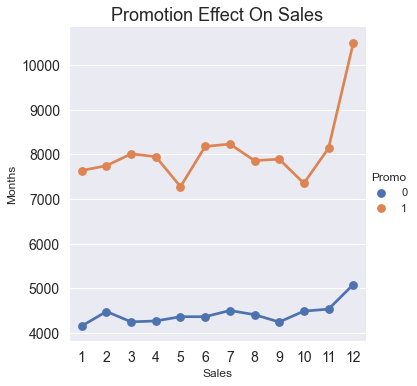

<Figure size 432x288 with 0 Axes>

In [36]:
sns.factorplot(data = merged_df, x ="Month", y = "Sales",
               hue = 'Promo')
plt.title("Promotion Effect On Sales", size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel="Sales", fontsize=12)
plt.ylabel(ylabel="Months", fontsize=12)
plt.show()
plt.savefig('../screenshots/PromoMonths.png')

>We can see from the scatter plot that promotion boosted sales.

###### YEAR

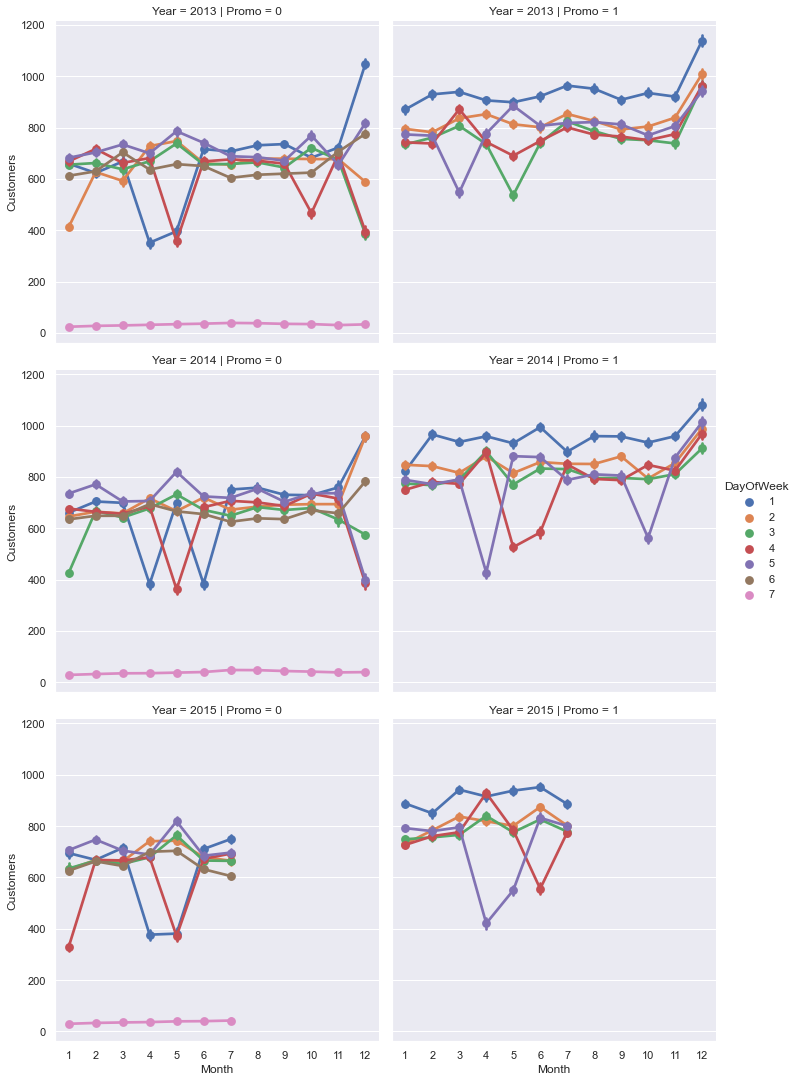

In [37]:
sns.catplot(data=train_df, x="Month", y="Customers",col='Promo',row="Year", hue='DayOfWeek', kind='point')


#### PROMOTION ON STORES

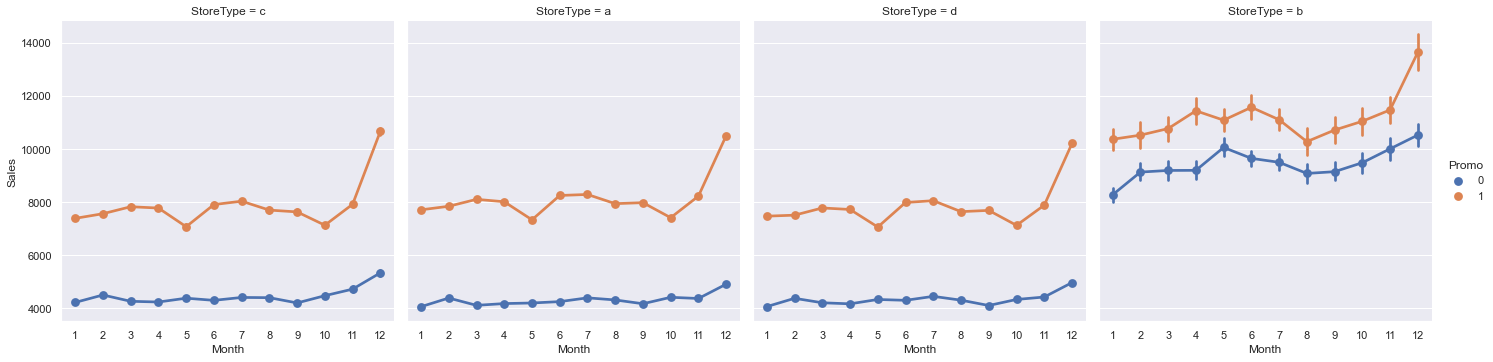

In [38]:
sns.factorplot(data = merged_df, x ="Month", y = "Sales", 
               col = 'StoreType',
               hue = 'Promo')
plt.savefig('../screenshots/effectPromoStore.png')

>Promotion has a considerable effect on increasing sales for store types A, C, and D.However, it has a smaller impact in store type B.

In [35]:
#creating joined dataframe(train and store)
merged_df = CleanStoreDf(train_df)
merged_df = merged_df.add_columns_from_another_df_using_column(store_df, 'Store', [
                                                               'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2'])

In [41]:
merged_df.to_csv('../data/store_train_merged.csv')

#### Are the promos attracting more customers?

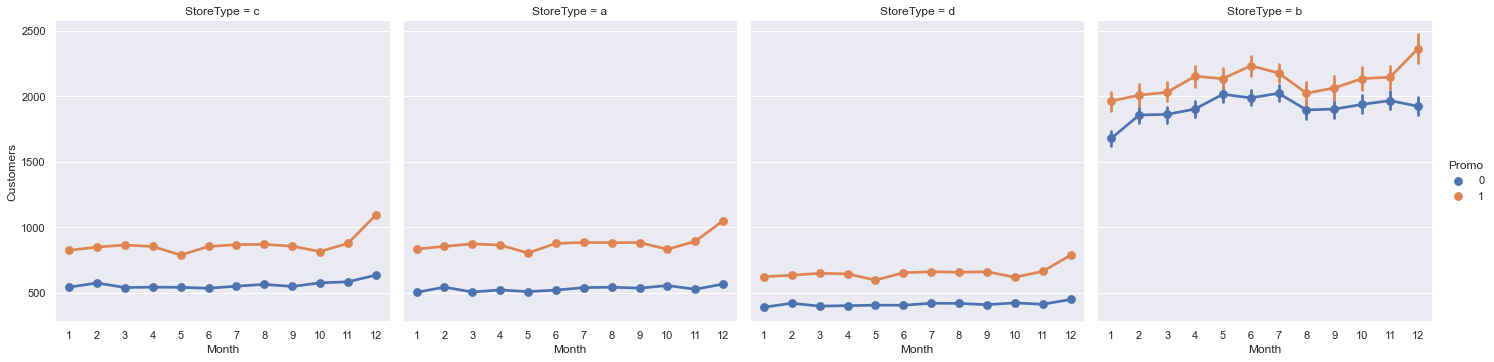

In [46]:
sns.factorplot(data = merged_df, x ="Month", y = "Customers", 
               col = 'StoreType',
               hue = 'Promo',
               title="Promotion effect on Attracting Customers For Each Store")

>Consumer numbers have increased modestly across different stores as a result of promotions.

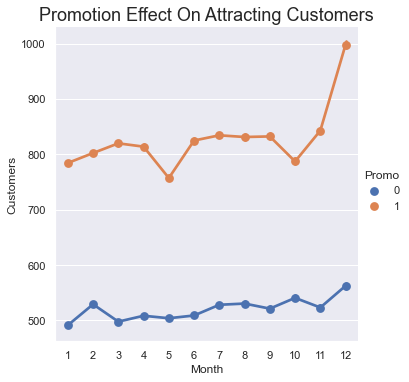

In [39]:
sns.factorplot(data = merged_df, x ="Month", y = "Customers",
               hue = 'Promo')
plt.title("Promotion Effect On Attracting Customers", size=18)
plt.savefig('../screenshots/effectPromoCust.png')

##### Checking if the new customers resulted in sales increase.

In [40]:
promo_customers_rln = train_df.loc[:,['Store','Customers','Promo','Sales']]
store_customer_difference = promo_customers_rln.groupby(['Store','Promo']).agg({'Customers':'mean','Sales':'mean'})
store_customer_difference.head(10)

Customers         Sales
Store Promo                           
1     0       399.682131   3198.994845
      1       577.522222   5152.886111
2     0       366.876289   2855.058419
      1       678.702778   6172.816667
3     0       477.445017   3967.596220
      1       851.213889   8608.666667
4     0       937.032646   6568.939863
      1      1363.613889  10370.511111
5     0       325.092784   2582.271478
      1       637.177778   5944.266667

In [46]:
customer_value = store_customer_difference.Customers.values.tolist()
def get_average_increase_from_all_stores(grouped_cutomer_list:list) -> float:
    percentage_increase = []
    i = 0
    while(i < len(grouped_cutomer_list)):
        new_perc = ((grouped_cutomer_list[i+1] * 100) / grouped_cutomer_list[i]) - 100
        percentage_increase.append(new_perc)
        i += 2

    return percentage_increase,sum(percentage_increase) / len(percentage_increase)

increase_list, average_increase = get_average_increase_from_all_stores(customer_value)

In [47]:
#Average increase across all stores
print('The average customer increase across all stores due to promotion is by: {:.2%}'.format(average_increase/100))
results.add_data('averageincreaseacross', average_increase/100)

The average customer increase across all stores due to promotion is by: 62.18%


In [48]:
def change_list_type(change_list) -> list:
    new_list = []
    for i in change_list:
        new_list.append(int(i))

    return new_list

In [49]:
#Getting Per-Store Customer Increase
customer_info = train_df.loc[:, ['Store', 'Customers']]
customer_info = customer_info.groupby('Store').agg({'Customers':'mean'})
customer_info['Customer Percentage Increase'] = change_list_type(increase_list)
customer_info['Customers'] = customer_info['Customers'].apply(lambda x: int(x))
results.add_data('cuspercincrease', customer_info)
customer_info.head(10)

,Customers,Customer Percentage Increase
Store,,
1,467,44
2,486,84
3,620,78
4,1100,45
5,444,95
6,525,74
7,791,65
8,547,86
9,479,57


>From the above anlysis, we could imply that promotions encourage existing customers to buy more rather than enticing new ones.

### <font color='saddlebrown'> Could the promos be deployed in more effective ways? Which stores should promos be deployed in?</font>

>It is more beneficial to focus promotions on store types A, B, and C.

### <font color='saddlebrown'>Trends of customer behavior during store open and closing times.</font>

In [50]:
customer_behaviour = train_df.groupby('Open').agg({'Customers':'mean','Sales':'mean'})
customer_behaviour

,Customers,Sales
Open,,
0,0.000000,0.000000
1,762.728395,6955.514291


##### DAY OF WEEK

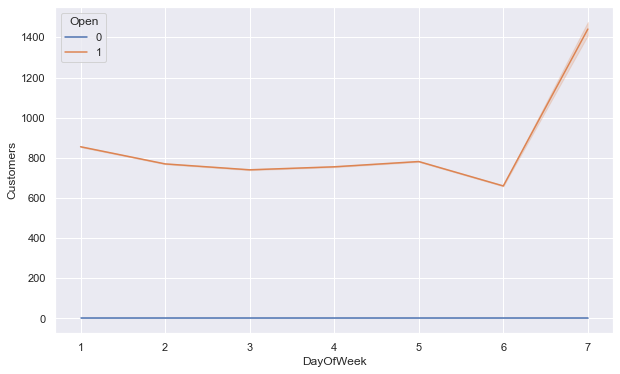

In [52]:
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="DayOfWeek",y="Customers",hue="Open",data=merged_df)
plt.savefig('../screenshots/openClosedDay.png')

##### MONTH

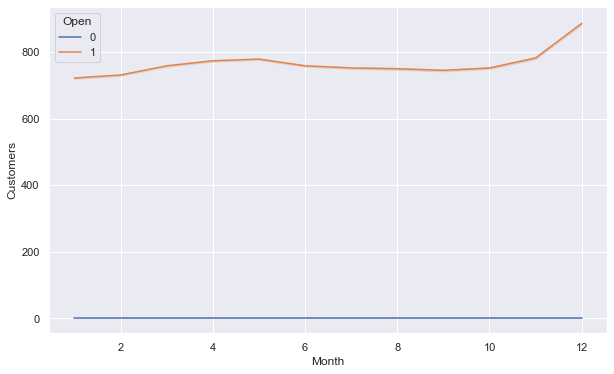

In [53]:
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="Month",y="Customers",hue="Open",data=merged_df)
plt.savefig('../screenshots/openClosedMon.png')

###### YEAR

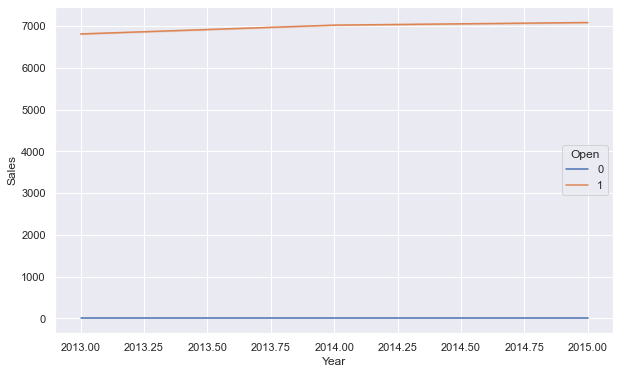

In [51]:
f, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x="Year",y="Sales",hue="Open",data=merged_df)
plt.savefig('../screenshots/openClosed.png')

>On closed days, there are clearly no customers.

### <font color='saddlebrown'>Which stores are opened on all weekdays? How does that affect their sales on weekends?</font>

In [64]:
x=merged_df[merged_df['DayOfWeek']==5].head()

In [65]:
weekend=merged_df[(merged_df['DayOfWeek']==6) | (merged_df['DayOfWeek']==7)]
weekday=merged_df[(merged_df['DayOfWeek']!=6) & (merged_df['DayOfWeek']!=7)]

In [68]:
weekend.groupby('Store')

In [70]:
weekday.groupby('Store')['Sales'].mean().reset_index().sort_values(by='Sales',ascending='False').head(10)

,Store,Sales
207,208,2768.894659
253,254,2801.589021
306,307,2869.813056
542,543,2914.200297
793,794,3076.216617
209,210,3109.887240
840,841,3158.872404
655,656,3161.157270
197,198,3179.388724
557,558,3200.660237


In [71]:
weekend.groupby('Store').agg({'Sales':'mean'}).sort_values(by='Sales',ascending=False).head()

,Sales
Store,
262,22994.376866
562,16441.298507
733,14579.511194
259,11605.753731
423,11059.324627


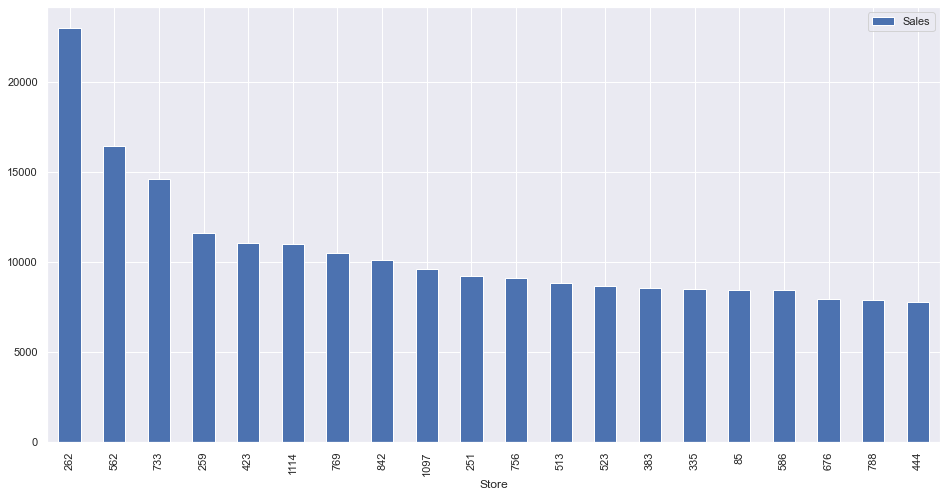

In [72]:
fig,ax=plt.subplots(figsize=(16,8))
weekend.groupby('Store').agg({'Sales':'mean'}).sort_values(by='Sales',ascending=False).head(20).plot(kind='bar',legend=True, ax=ax)
plt.savefig('../screenshots/weekendStoreSles.png')

>Weekend sales on diffrent stores

### <font color='saddlebrown'>Check how the assortment type affects sales.</font>

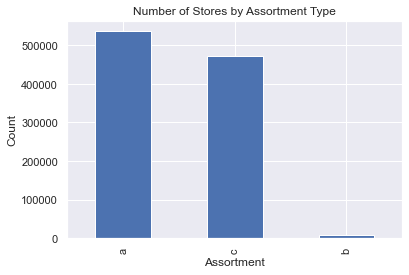

<Figure size 432x288 with 0 Axes>

In [54]:
merged_df['Assortment'].value_counts().plot(kind='bar')
plt.xlabel('Assortment'),plt.ylabel('Count')
plt.title('Number of Stores by Assortment Type')
plt.show()
plt.savefig('../screenshots/AssortType.png')

`a = basic, b = extra, c = extended.`

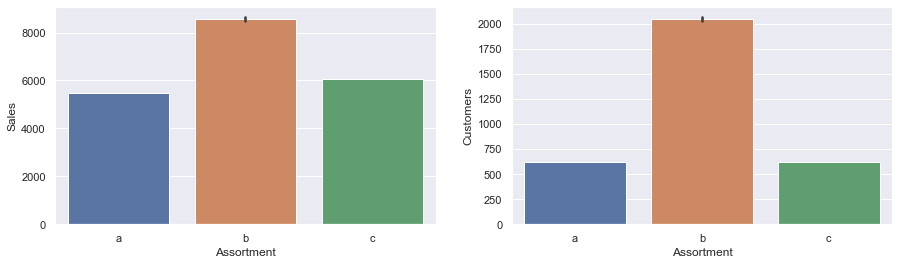

<Figure size 432x288 with 0 Axes>

In [56]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))

sns.barplot(x='Assortment', y='Sales', data=merged_df, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=merged_df, order=['a','b','c'], ax=axis2)
plt.show()
plt.savefig('../screenshots/SalesCustAssort.png')

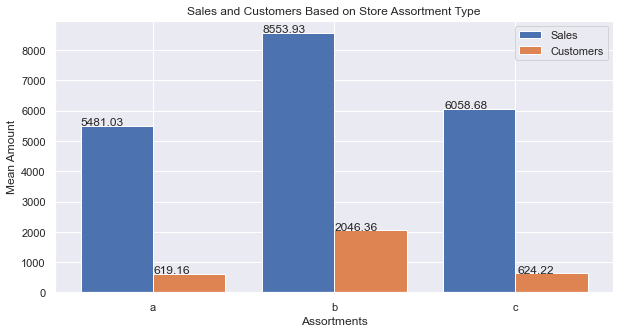

<Figure size 432x288 with 0 Axes>

In [57]:
assortment_sales_rln = merged_df.loc[:, ['Assortment', 'Sales', 'Customers']]
assortment_sales_rln = assortment_sales_rln.groupby(
    "Assortment").agg({'Sales': 'mean', 'Customers': 'mean'})

X_axis = np.arange(len(assortment_sales_rln.index))
plt.figure(figsize=(10, 5))
plt1 = plt.bar(X_axis - 0.2, assortment_sales_rln['Sales'], 0.4, label='Sales')
for p in plt1.patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x()
                                                   * 1.005, p.get_height() * 1.005))
plt2 = plt.bar(X_axis + 0.2, assortment_sales_rln['Customers'], 0.4, label='Customers')
for p in plt2.patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x()
                                                   * 1.005, p.get_height() * 1.005))

plt.xticks(X_axis, assortment_sales_rln.index)
plt.xlabel("Assortments")
plt.ylabel("Mean Amount")
plt.title("Sales and Customers Based on Store Assortment Type")
plt.legend()
plt.show()
plt.savefig('../screenshots/SalesCustAssort2.png')

### <font color='saddlebrown'>How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?</font>

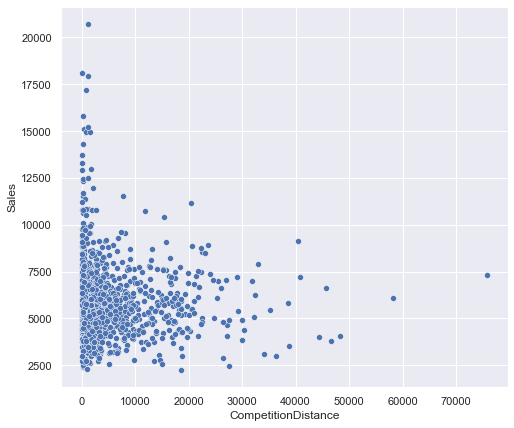

<Figure size 432x288 with 0 Axes>

In [62]:
competition_df = merged_df.groupby('Store').agg({
    'CompetitionDistance': 'mean',
    'Sales': 'mean',
    'Customers': 'mean'
})
plt.subplots(figsize = (8, 7))
sns.scatterplot(x='CompetitionDistance', y='Sales', data=competition_df)
plt.show()
plt.savefig('../screenshots/SalesCustscat.png')

In [60]:
competition_df_agg = competition_df.groupby("Store").agg({"Sales": "sum", "Customers" : "sum",
                                                      "CompetitionDistance": lambda x: max(x)})


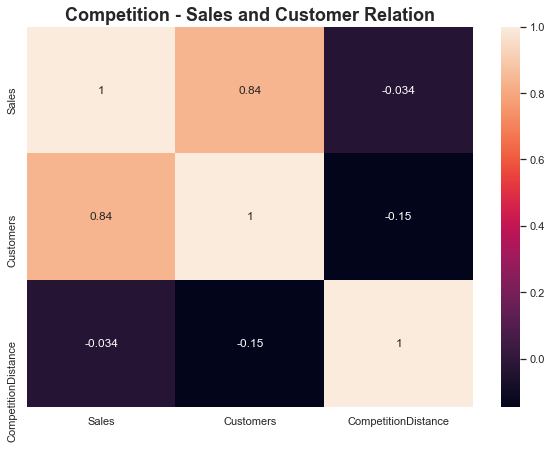

In [61]:
group_comp_dist_corr = competition_df_agg.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(group_comp_dist_corr, annot=True)
plt.title('Competition - Sales and Customer Relation', size=18, fontweight='bold')
plt.savefig('../screenshots/SalesCompetion.png')

>The competition distance and sales have a relatively low correlation. This indicates that competition distance has little effect on sales.

***
***